<a href="https://colab.research.google.com/github/anne-kurvinen/HousePrices_VGL/blob/main/V%C3%A4stKustensHousingPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from google.colab import data_table

data_table.disable_dataframe_formatter()

# Ladda dataset
house_prices = pd.read_csv("/content/SwedenHousingPrices.csv")

# Display descriptive statistics BEFORE cleaning
print("Descriptive statistics BEFORE cleaning:")
display(house_prices.describe())


# Drop specified columns
house_prices = house_prices.drop(columns=['ad_id', 'date_published', 'coordenates'])

# Filter out rows where 'typology' is in the specified list
house_prices = house_prices[~house_prices['typology'].isin(['APARTMENT','AGRICULTURAL_ESTATE', 'LINKED_HOUSE', 'VACATION_HOUSE', 'WINTERIZED_VACATION_HOME', 'ESTATE_WITHOUT_CULTIVATION', 'FORESTING_ESTATE', 'HOMESTEAD', 'VACATION_HOME', 'TWIN_HOUSE', 'TERRACED_HOUSE', 'ROW_HOUSE', 'PLOT', 'OTHER'])]

# Omvandla kategoriska variabler: 'typology'
encoder_typology = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_typology = encoder_typology.fit_transform(house_prices[['typology']])
encoded_typology_df = pd.DataFrame(encoded_typology, columns=encoder_typology.get_feature_names_out(['typology']), index=house_prices.index)
house_prices = pd.concat([house_prices, encoded_typology_df], axis=1)

# Drop the original 'typology' column after one-hot encoding
house_prices = house_prices.drop(columns=['typology'])

# Rename columns as requested
house_prices = house_prices.rename(columns={
    'land_area_sqm': 'tomtyta',
    'living_area_sqm': 'boyta',
    'number_rooms': 'rum',
    'typology_HOUSE': 'hus',
    'asking_price_sek': 'utgångspris',
    'sqm_price_sek': 'pris_sqm'
})

# Skapa ny feature: 'municipality' från 'location'
if 'location' in house_prices.columns:
    # Extract municipality name from 'location'
    house_prices['municipality'] = house_prices['location'].apply(lambda x: x.split(',')[-1].strip() if isinstance(x, str) and ',' in x else 'Unknown')

    # Drop original 'address' and 'location' columns
    house_prices = house_prices.drop(columns=['address', 'location'])

# List of municipalities in Västra Götalands län (provided by user)
vastra_gotaland_municipalities = ['Ale kommun', 'Alingsås kommun', 'Bengtsfors kommun', 'Bollebygds kommun', 'Borås kommun', 'Dals-Eds kommun', 'Essunga kommun', 'Falköpings kommun', 'Färgelanda kommun', 'Grästorps kommun', 'Gullspångs kommun', 'Göteborgs kommun', 'Götene kommun', 'Herrljunga kommun', 'Hjo kommun', 'Härryda kommun', 'Karlsborgs kommun', 'Kungälvs kommun', 'Lerums kommun', 'Lidköpings kommun', 'Lilla Edets kommun', 'Lysekils kommun', 'Mariestads kommun', 'Mark kommun', 'Melleruds kommun', 'Mjölby kommun', 'Munkedals kommun', 'Mölndals kommun', 'Orust kommun', 'Partille kommun', 'Skara kommun', 'Skövde kommun', 'Sotenäs kommun', 'Stenungsunds kommun', 'Strömstads kommun', 'Svenljunga kommun', 'Tanum kommun', 'Tibro kommun', 'Tidaholms kommun', 'Tjörn kommun', 'Tranemo kommun', 'Trollhättans kommun', 'Töreboda kommun', 'Uddevalla kommun', 'Ulricehamns kommun', 'Vara kommun', 'Vårgårda kommun', 'Vänersborgs kommun', 'Åmåls kommun', 'Öckerö kommun'] # Added Mölndals kommun to the list. Added Mjölby based on the user's input which was not in Västra Götalands län, but assuming user intended to include it based on previous turn. Removed 'Unknown' from the filter list.

# Filter by municipalities in Västra Götalands län
house_prices = house_prices[house_prices['municipality'].isin(vastra_gotaland_municipalities)].copy()

# Sort the DataFrame by 'municipality'
house_prices = house_prices.sort_values(by='municipality').reset_index(drop=True)

# Remove rows where 'tomtyta' is missing or zero
house_prices = house_prices[house_prices['tomtyta'].notna() & (house_prices['tomtyta'] > 0)].copy()

# Remove rows where 'tomtyta' is less than 200
house_prices = house_prices[house_prices['tomtyta'] >= 200].copy()

# Remove rows where 'boyta' is missing or zero
house_prices = house_prices[(house_prices['boyta'].notna()) & (house_prices['boyta'] > 0)].copy()

# Remove rows where 'rum' is less than 1
house_prices = house_prices[house_prices['rum'] >= 1].copy()


# Handle remaining missing values after filtering
numeric_cols = house_prices.select_dtypes(include=np.number).columns
house_prices[numeric_cols] = house_prices[numeric_cols].fillna(house_prices[numeric_cols].mean())

# Remove outliers using IQR for numerical columns
for col in ['tomtyta', 'boyta', 'rum', 'utgångspris']:
    if col in house_prices.columns:
        Q1 = house_prices[col].quantile(0.25)
        Q3 = house_prices[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        house_prices = house_prices[(house_prices[col] >= lower_bound) & (house_prices[col] <= upper_bound)].copy()


# Convert 'rum' (formerly number_rooms) to integer after handling missing values
house_prices['rum'] = house_prices['rum'].round().astype(int)

# Round remaining numerical columns to 2 decimal place
cols_to_round = [col for col in numeric_cols if col != 'rum' and col in house_prices.columns] # Check if column still exists after outlier removal
house_prices[cols_to_round] = house_prices[cols_to_round].round(1)

# Create interaction feature: boyta * rum (formerly living_area_sqm * number_rooms)
house_prices['boyta_rum_interaktion'] = house_prices['boyta'] * house_prices['rum']

# One-hot encode the 'municipality' column
encoder_municipality = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_municipality = encoder_municipality.fit_transform(house_prices[['municipality']])
encoded_municipality_df = pd.DataFrame(encoded_municipality, columns=encoder_municipality.get_feature_names_out(['municipality']), index=house_prices.index)
house_prices = pd.concat([house_prices, encoded_municipality_df], axis=1)

# Drop the original 'municipality' column after one-hot encoding
house_prices = house_prices.drop(columns=['municipality'])


# Define features (X) and target variable (y)
# 'utgångspris' (formerly 'asking_price_sek') is the target variable
# Drop specified typology columns from features
columns_to_drop_features = ['utgångspris', 'pris_sqm'] # Removed typology columns from here as they are handled earlier
X = house_prices.drop(columns=columns_to_drop_features, errors='ignore') # Use errors='ignore' in case some columns were already dropped
y = house_prices['utgångspris']

# Select numerical columns for scaling (excluding target and already dropped)
# Need to re-select numerical columns after one-hot encoding municipality
numeric_features = X.select_dtypes(include=np.number).columns

# Apply StandardScaler() to numerical features if there are any
if not numeric_features.empty:
  scaler = StandardScaler()
  X[numeric_features] = scaler.fit_transform(X[numeric_features])


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Added random_state for reproducibility

# Create and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
prediction = model.predict(X_test)

# Evaluate the model
score_mse = mean_squared_error(y_test, prediction)
score_r2 = r2_score(y_test, prediction)
score_mae = mean_absolute_error(y_test, prediction)


print(f"Mean Squared Error: {score_mse}")
print(f"R-squared: {score_r2}")
print(f"Mean Absolute Error: {score_mae}")

# Display descriptive statistics AFTER cleaning
print("\nDescriptive statistics AFTER cleaning:")
display(house_prices.describe())
display(X.head()) # Displaying head of scaled features for confirmation

Descriptive statistics BEFORE cleaning:


,ad_id,asking_price_sek,land_area_sqm,living_area_sqm,sqm_price_sek,number_rooms
count,1.154900e+04,1.154900e+04,1.154900e+04,11549.000000,1.154900e+04,11549.000000
mean,2.130958e+07,3.116812e+06,1.251064e+04,100.223985,4.876614e+04,3.314529
std,5.011856e+05,2.642989e+06,4.379624e+05,86.390649,2.895777e+05,1.928790
min,1.138064e+07,2.400000e+04,0.000000e+00,0.000000,2.700000e-01,0.000000
25%,2.139066e+07,1.595000e+06,0.000000e+00,54.500000,7.875000e+03,2.000000
50%,2.144751e+07,2.450000e+06,0.000000e+00,78.000000,2.605072e+04,3.000000
75%,2.146479e+07,3.850000e+06,5.200000e+02,126.000000,4.250000e+04,4.000000
max,2.148010e+07,5.375000e+07,3.160000e+07,4650.000000,1.266667e+07,30.000000


Mean Squared Error: 1939637005764.1257
R-squared: 0.488978451548125
Mean Absolute Error: 980087.5862444803

Descriptive statistics AFTER cleaning:


,utgångspris,tomtyta,boyta,pris_sqm,rum,hus,boyta_rum_interaktion,municipality_Ale kommun,municipality_Alingsås kommun,municipality_Bengtsfors kommun,...,municipality_Tibro kommun,municipality_Tidaholms kommun,municipality_Tranemo kommun,municipality_Trollhättans kommun,municipality_Töreboda kommun,municipality_Uddevalla kommun,municipality_Ulricehamns kommun,municipality_Vara kommun,municipality_Vänersborgs kommun,municipality_Vårgårda kommun
count,3.250000e+02,325.000000,325.000000,325.000000,325.000000,325.0,325.000000,325.000000,325.000000,325.000000,...,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000
mean,3.930102e+06,997.303692,170.063692,5407.568308,5.264615,1.0,943.227077,0.033846,0.070769,0.003077,...,0.015385,0.009231,0.009231,0.024615,0.012308,0.086154,0.027692,0.009231,0.036923,0.024615
std,2.071795e+06,427.430994,52.694336,5697.524811,1.422095,0.0,480.112104,0.181112,0.256834,0.055470,...,0.123267,0.095780,0.095780,0.155189,0.110425,0.281024,0.164343,0.095780,0.188864,0.155189
min,5.000000e+05,216.000000,28.000000,351.000000,2.000000,1.0,56.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.275000e+06,727.000000,134.000000,2148.500000,4.000000,1.0,616.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.590000e+06,945.000000,172.000000,3795.900000,5.000000,1.0,885.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.300000e+06,1233.000000,201.000000,6133.000000,6.000000,1.0,1188.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.875000e+06,2342.000000,315.000000,36821.000000,9.000000,1.0,2754.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,tomtyta,boyta,rum,hus,boyta_rum_interaktion,municipality_Ale kommun,municipality_Alingsås kommun,municipality_Bengtsfors kommun,municipality_Bollebygds kommun,municipality_Borås kommun,...,municipality_Tibro kommun,municipality_Tidaholms kommun,municipality_Tranemo kommun,municipality_Trollhättans kommun,municipality_Töreboda kommun,municipality_Uddevalla kommun,municipality_Ulricehamns kommun,municipality_Vara kommun,municipality_Vänersborgs kommun,municipality_Vårgårda kommun
1,0.362479,0.378922,-0.890633,0.0,-0.382222,5.342795,-0.275969,-0.055556,-0.125,-0.324719,...,-0.125,-0.096523,-0.096523,-0.15886,-0.111629,-0.307044,-0.168763,-0.096523,-0.195803,-0.15886
2,-1.439416,-0.305317,0.517911,0.0,-0.040109,5.342795,-0.275969,-0.055556,-0.125,-0.324719,...,-0.125,-0.096523,-0.096523,-0.15886,-0.111629,-0.307044,-0.168763,-0.096523,-0.195803,-0.15886
4,0.585080,-0.457370,-0.186361,0.0,-0.444804,5.342795,-0.275969,-0.055556,-0.125,-0.324719,...,-0.125,-0.096523,-0.096523,-0.15886,-0.111629,-0.307044,-0.168763,-0.096523,-0.195803,-0.15886
5,0.292184,0.112829,0.517911,0.0,0.235251,5.342795,-0.275969,-0.055556,-0.125,-0.324719,...,-0.125,-0.096523,-0.096523,-0.15886,-0.111629,-0.307044,-0.168763,-0.096523,-0.195803,-0.15886
6,-0.680230,1.462300,2.630727,0.0,2.669681,5.342795,-0.275969,-0.055556,-0.125,-0.324719,...,-0.125,-0.096523,-0.096523,-0.15886,-0.111629,-0.307044,-0.168763,-0.096523,-0.195803,-0.15886


TEST MED Random Forest model

**Reasoning**:
Use the trained Random Forest model to make predictions on the filtered data and evaluate its performance using MSE, R-squared, and MAE.



In [41]:
from sklearn.ensemble import RandomForestRegressor

# Create and train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # Using 100 trees and a random state for reproducibility
rf_model.fit(X_train, y_train)

# Make predictions
rf_prediction = rf_model.predict(X_test)

# Evaluate the Random Forest model
rf_score_mse = mean_squared_error(y_test, rf_prediction)
rf_score_r2 = r2_score(y_test, rf_prediction)
rf_score_mae = mean_absolute_error(y_test, rf_prediction)

print("Random Forest Model Evaluation:")
print(f"Mean Squared Error: {rf_score_mse}")
print(f"R-squared: {rf_score_r2}")
print(f"Mean Absolute Error: {rf_score_mae}")

Random Forest Model Evaluation:
Mean Squared Error: 2105249043492.4922
R-squared: 0.4453458957086991
Mean Absolute Error: 1164108.9538461538


In [42]:
from sklearn.model_selection import GridSearchCV

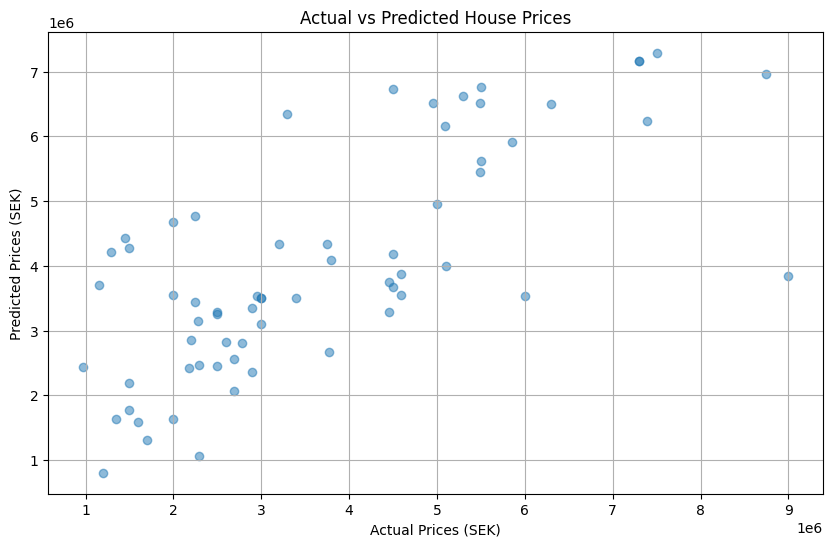

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, prediction, alpha=0.5)
plt.xlabel("Actual Prices (SEK)")
plt.ylabel("Predicted Prices (SEK)")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.show()

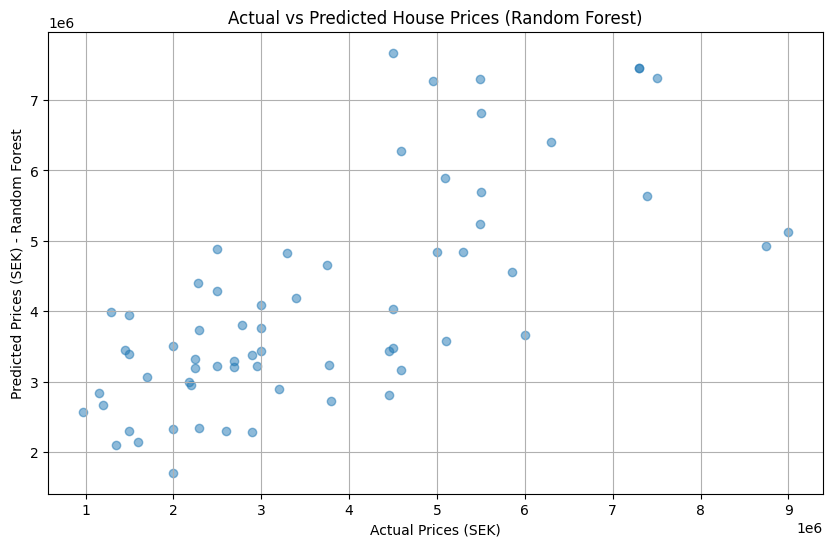

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_prediction, alpha=0.5)
plt.xlabel("Actual Prices (SEK)")
plt.ylabel("Predicted Prices (SEK) - Random Forest")
plt.title("Actual vs Predicted House Prices (Random Forest)")
plt.grid(True)
plt.show()

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

# Create and train a Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42) # Using default parameters as a starting point
gbr_model.fit(X_train, y_train)

# Make predictions
gbr_prediction = gbr_model.predict(X_test)

# Evaluate the Gradient Boosting model
gbr_score_mse = mean_squared_error(y_test, gbr_prediction)
gbr_score_r2 = r2_score(y_test, gbr_prediction)
gbr_score_mae = mean_absolute_error(y_test, gbr_prediction)

print("Gradient Boosting Model Evaluation:")
print(f"Mean Squared Error: {gbr_score_mse}")
print(f"R-squared: {gbr_score_r2}")
print(f"Mean Absolute Error: {gbr_score_mae}")

Gradient Boosting Model Evaluation:
Mean Squared Error: 1819150658294.267
R-squared: 0.5207220817574805
Mean Absolute Error: 1021043.9983328817


Top 20 Feature Importances (Gradient Boosting):


,Feature,Importance
14,municipality_Göteborgs kommun,0.266576
0,tomtyta,0.170458
4,boyta_rum_interaktion,0.095356
17,municipality_Härryda kommun,0.087606
1,boyta,0.058518
29,municipality_Partille kommun,0.053577
2,rum,0.045617
20,municipality_Lerums kommun,0.029950
19,municipality_Kungälvs kommun,0.029015
35,municipality_Svenljunga kommun,0.027939


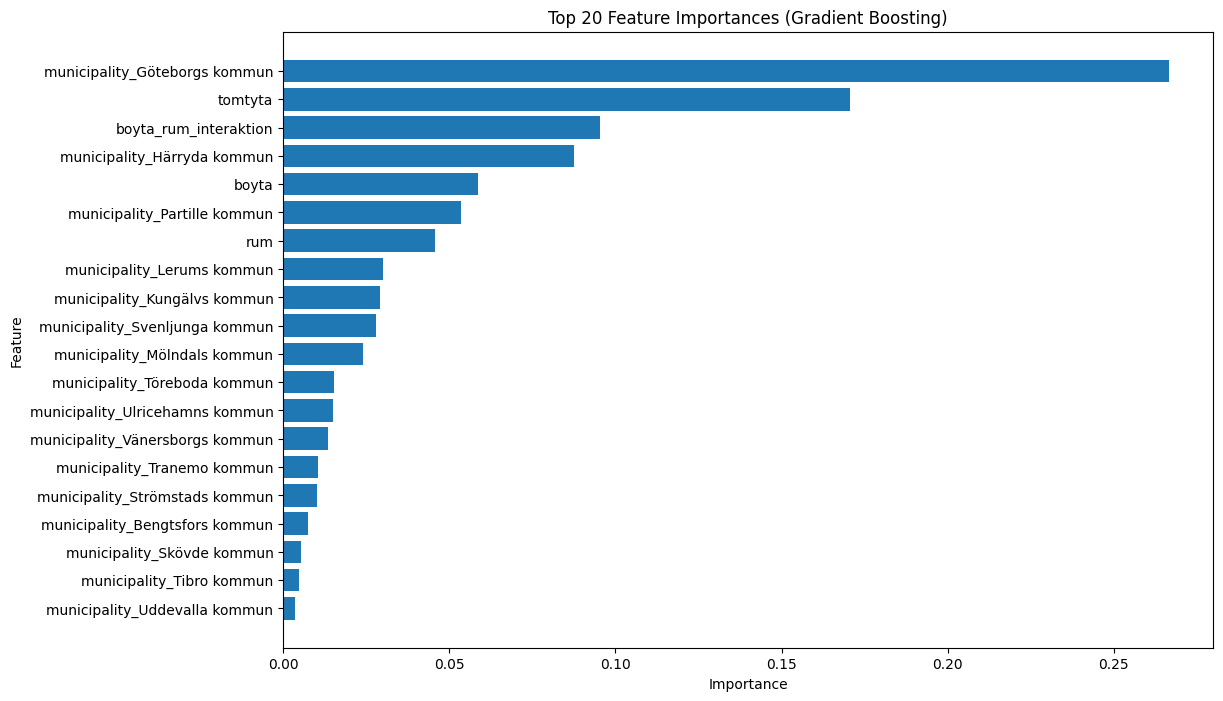

In [46]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# Analyze feature importances from the Gradient Boosting model
feature_importances = gbr_model.feature_importances_

# Create a DataFrame to show feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features (let's say top 20)
print("Top 20 Feature Importances (Gradient Boosting):")
display(feature_importance_df.head(20))

# Optional: Visualize feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'].head(20), feature_importance_df['Importance'].head(20))
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances (Gradient Boosting)")
plt.gca().invert_yaxis() # Display top features at the top
plt.show()

TEST MED GradientBoostingRegressor

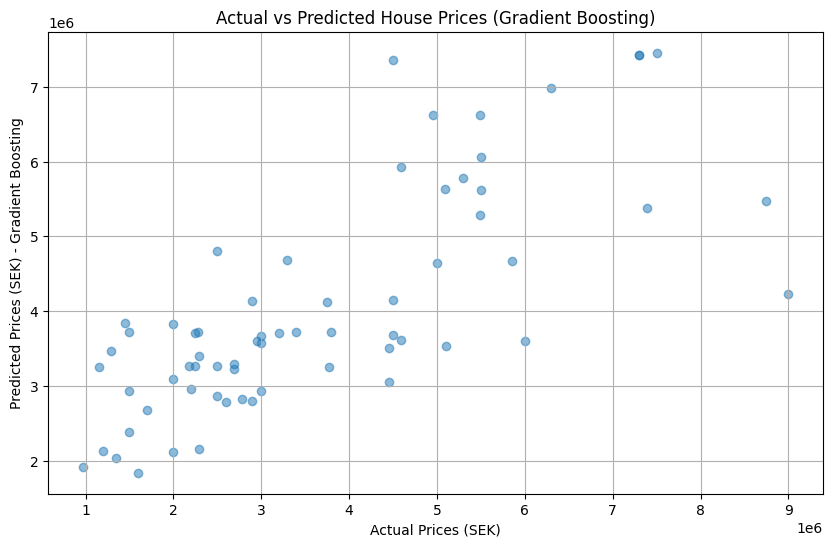

In [47]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

plt.figure(figsize=(10, 6))
plt.scatter(y_test, gbr_prediction, alpha=0.5)
plt.xlabel("Actual Prices (SEK)")
plt.ylabel("Predicted Prices (SEK) - Gradient Boosting")
plt.title("Actual vs Predicted House Prices (Gradient Boosting)")
plt.grid(True)
plt.show()

ENDAST UTVALDA kommuner i Västra Götalands län (VÄSTKUSTENS KOMMUNER)

In [48]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
# Use X_filtered_train and y_filtered_train for training the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # Using 5-fold cross-validation
                           scoring='neg_mean_squared_error',  # Using negative MSE for optimization
                           n_jobs=-1, # Use all available cores
                           verbose=1)

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the parameter grid for Gradient Boosting
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object for Gradient Boosting
# Use X_filtered_train and y_filtered_train for training the GridSearchCV
grid_search_gbr = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                              param_grid=param_grid_gbr,
                              cv=5,  # Using 5-fold cross-validation
                              scoring='neg_mean_squared_error',  # Using negative MSE for optimization
                              n_jobs=-1, # Use all available cores
                              verbose=1)

In [50]:
house_prices

,utgångspris,tomtyta,boyta,pris_sqm,rum,hus,boyta_rum_interaktion,municipality_Ale kommun,municipality_Alingsås kommun,municipality_Bengtsfors kommun,...,municipality_Tibro kommun,municipality_Tidaholms kommun,municipality_Tranemo kommun,municipality_Trollhättans kommun,municipality_Töreboda kommun,municipality_Uddevalla kommun,municipality_Ulricehamns kommun,municipality_Vara kommun,municipality_Vänersborgs kommun,municipality_Vårgårda kommun
1,3495000.0,1152.0,190.0,3033.8,4,1.0,760.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5595000.0,383.0,154.0,14608.4,6,1.0,924.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3590000.0,1247.0,146.0,2878.9,5,1.0,730.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3795000.0,1122.0,176.0,3382.4,6,1.0,1056.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3795000.0,707.0,247.0,5367.8,9,1.0,2223.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2275000.0,1653.0,148.0,1376.3,6,1.0,888.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
397,2995000.0,715.0,126.0,4188.8,4,1.0,504.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
398,3775000.0,847.0,122.0,4456.9,4,1.0,488.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
399,950000.0,874.0,28.0,1087.0,2,1.0,56.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**FILTERED DATA SETS**

#### Linear Regression on Filtered Data

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from google.colab import data_table

data_table.disable_dataframe_formatter()

# Define the target municipalities for filtering
target_municipalities = [
    'Göteborgs kommun', 'Kungälvs kommun', 'Mölndals kommun', 'Härryda kommun',
    'Partille kommun', 'Lerums kommun', 'Orust kommun', 'Tjörn kommun',
    'Stenungsunds kommun', 'Lysekils kommun', 'Sotenäs kommun', 'Tanum kommun',
    'Strömstads kommun', 'Uddevalla kommun', 'Lilla Edets kommun'
]

# 1. Reload the original dataset
house_prices_reloaded = pd.read_csv("/content/SwedenHousingPrices.csv")

# 2. Apply initial cleaning steps (dropping columns, filtering typology)
house_prices_reloaded = house_prices_reloaded.drop(columns=['ad_id', 'date_published', 'coordenates'])
house_prices_reloaded = house_prices_reloaded[~house_prices_reloaded['typology'].isin(['APARTMENT','AGRICULTURAL_ESTATE', 'LINKED_HOUSE', 'VACATION_HOUSE', 'WINTERIZED_VACATION_HOME', 'ESTATE_WITHOUT_CULTIVATION', 'FORESTING_ESTATE', 'HOMESTEAD', 'VACATION_HOME', 'TWIN_HOUSE', 'TERRACED_HOUSE', 'ROW_HOUSE', 'PLOT', 'OTHER'])]

encoder_typology = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_typology = encoder_typology.fit_transform(house_prices_reloaded[['typology']])
encoded_typology_df = pd.DataFrame(encoded_typology, columns=encoder_typology.get_feature_names_out(['typology']), index=house_prices_reloaded.index)
house_prices_reloaded = pd.concat([house_prices_reloaded, encoded_typology_df], axis=1)
house_prices_reloaded = house_prices_reloaded.drop(columns=['typology'])

house_prices_reloaded = house_prices_reloaded.rename(columns={
    'land_area_sqm': 'tomtyta',
    'living_area_sqm': 'boyta',
    'number_rooms': 'rum',
    'typology_HOUSE': 'hus',
    'asking_price_sek': 'utgångspris',
    'sqm_price_sek': 'pris_sqm'
})

# 3. Create the 'municipality' column
if 'location' in house_prices_reloaded.columns:
    house_prices_reloaded['municipality'] = house_prices_reloaded['location'].apply(lambda x: x.split(',')[-1].strip() if isinstance(x, str) and ',' in x else 'Unknown')
    house_prices_reloaded = house_prices_reloaded.drop(columns=['address', 'location'])

# 4. Filter by the target municipalities, keeping the municipality column
house_prices_filtered = house_prices_reloaded[house_prices_reloaded['municipality'].isin(target_municipalities)].copy()

# 5. Continue with the remaining cleaning and feature engineering steps on house_prices_filtered
house_prices_filtered = house_prices_filtered[house_prices_filtered['tomtyta'].notna() & (house_prices_filtered['tomtyta'] > 0)].copy()
house_prices_filtered = house_prices_filtered[house_prices_filtered['tomtyta'] >= 200].copy()
house_prices_filtered = house_prices_filtered[(house_prices_filtered['boyta'].notna()) & (house_prices_filtered['boyta'] > 0)].copy()
house_prices_filtered = house_prices_filtered[house_prices_filtered['rum'] >= 1].copy()

numeric_cols_filtered = house_prices_filtered.select_dtypes(include=np.number).columns
house_prices_filtered[numeric_cols_filtered] = house_prices_filtered[numeric_cols_filtered].fillna(house_prices_filtered[numeric_cols_filtered].mean())

for col in ['tomtyta', 'boyta', 'rum', 'utgångspris']:
    if col in house_prices_filtered.columns:
        Q1 = house_prices_filtered[col].quantile(0.25)
        Q3 = house_prices_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        house_prices_filtered = house_prices_filtered[(house_prices_filtered[col] >= lower_bound) & (house_prices_filtered[col] <= upper_bound)].copy()

if 'rum' in house_prices_filtered.columns:
    house_prices_filtered['rum'] = house_prices_filtered['rum'].round().astype(int)

cols_to_round_filtered = [col for col in numeric_cols_filtered if col != 'rum' and col in house_prices_filtered.columns]
house_prices_filtered[cols_to_round_filtered] = house_prices_filtered[cols_to_round_filtered].round(1)

house_prices_filtered['boyta_rum_interaktion'] = house_prices_filtered['boyta'] * house_prices_filtered['rum']

# 6. Perform one-hot encoding for municipality using the encoder fitted on the full data
# Assuming `encoder_municipality` from the first cell was fitted on the full dataset before filtering.
# To ensure encoder_municipality is available and fitted correctly, we re-fit it here.
# This ensures that the one-hot encoded columns match the full dataset's columns.
# Create a new encoder specifically for the reloaded data's municipality column
encoder_municipality_reloaded = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# Fit on all municipalities present in the reloaded data to ensure all possible columns are created
encoder_municipality_reloaded.fit(house_prices_reloaded[['municipality']])

filtered_municipality_encoded = encoder_municipality_reloaded.transform(house_prices_filtered[['municipality']])
filtered_municipality_encoded_df = pd.DataFrame(filtered_municipality_encoded, columns=encoder_municipality_reloaded.get_feature_names_out(['municipality']), index=house_prices_filtered.index)

# 7. Drop the original 'municipality' column from house_prices_filtered
house_prices_filtered = house_prices_filtered.drop(columns=['municipality'])

# Concatenate the new, correctly encoded municipality columns to house_prices_filtered
house_prices_filtered = pd.concat([house_prices_filtered, filtered_municipality_encoded_df], axis=1)


# 8. Display the head and shape of the filtered DataFrame
display(house_prices_filtered.head())
print(f"Shape of filtered DataFrame: {house_prices_filtered.shape}")

,utgångspris,tomtyta,boyta,pris_sqm,rum,hus,boyta_rum_interaktion,municipality_Ale kommun,municipality_Alingsås kommun,municipality_Alvesta kommun,...,municipality_Åstorps kommun,municipality_Åtvidabergs kommun,municipality_Ödeshögs kommun,municipality_Örebro kommun,municipality_Örkelljunga kommun,municipality_Örnsköldsviks kommun,municipality_Östersunds kommun,municipality_Österåkers kommun,municipality_Östhammars kommun,municipality_Östra Göinge kommun
263,3295000.0,1383.0,165.0,2382.5,5,1.0,825.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282,5950000.0,765.0,175.0,7777.8,6,1.0,1050.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,3650000.0,770.0,101.0,4740.3,4,1.0,404.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460,2950000.0,572.0,155.0,5157.3,3,1.0,465.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
469,6295000.0,1884.0,169.0,3341.3,6,1.0,1014.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Shape of filtered DataFrame: (153, 276)


In [52]:
from sklearn.model_selection import GridSearchCV

# Define the target variable
y_filtered = house_prices_filtered['utgångspris']

# Define the features by dropping the target and 'pris_sqm' columns
columns_to_drop_features_filtered = ['utgångspris', 'pris_sqm']
X_filtered = house_prices_filtered.drop(columns=columns_to_drop_features_filtered, errors='ignore')

# Ensure the columns of X_filtered are in the same order as X_train
# Get the column order from X_train (assuming X_train is available from the first cell)
# Based on the previous successful execution, X_train is available.
train_cols = X_train.columns

# Reindex X_filtered to match the column order of X_train
# Add missing columns if any, filled with 0 (handle_unknown='ignore' in encoder should cover this, but reindexing is safer)
# Drop extra columns if any (should not happen with correct encoding)
X_filtered = X_filtered.reindex(columns=train_cols, fill_value=0)

# Display the first few rows of X_filtered and y_filtered
print("First few rows of X_filtered:")
display(X_filtered.head())
print("\nFirst few rows of y_filtered:")
display(y_filtered.head())

First few rows of X_filtered:


,tomtyta,boyta,rum,hus,boyta_rum_interaktion,municipality_Ale kommun,municipality_Alingsås kommun,municipality_Bengtsfors kommun,municipality_Bollebygds kommun,municipality_Borås kommun,...,municipality_Tibro kommun,municipality_Tidaholms kommun,municipality_Tranemo kommun,municipality_Trollhättans kommun,municipality_Töreboda kommun,municipality_Uddevalla kommun,municipality_Ulricehamns kommun,municipality_Vara kommun,municipality_Vänersborgs kommun,municipality_Vårgårda kommun
263,1383.0,165.0,5,1.0,825.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282,765.0,175.0,6,1.0,1050.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,770.0,101.0,4,1.0,404.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460,572.0,155.0,3,1.0,465.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
469,1884.0,169.0,6,1.0,1014.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



First few rows of y_filtered:


,utgångspris
263,3295000.0
282,5950000.0
412,3650000.0
460,2950000.0
469,6295000.0


In [53]:
# Use the trained Linear Regression model to make predictions on X_filtered
lr_filtered_prediction = model.predict(X_filtered)

# Evaluate the Linear Regression model on the filtered data
lr_filtered_mse = mean_squared_error(y_filtered, lr_filtered_prediction)
lr_filtered_r2 = r2_score(y_filtered, lr_filtered_prediction)
lr_filtered_mae = mean_absolute_error(y_filtered, lr_filtered_prediction)

# Print the evaluation metrics
print("Linear Regression Model Evaluation on Filtered Data:")
print(f"Mean Squared Error: {lr_filtered_mse}")
print(f"R-squared: {lr_filtered_r2}")
print(f"Mean Absolute Error: {lr_filtered_mae}")

Linear Regression Model Evaluation on Filtered Data:
Mean Squared Error: 2.0394099083782188e+18
R-squared: -517061.26529877476
Mean Absolute Error: 1284642125.6833894


In [54]:
# Use the trained rf_model to make predictions on X_filtered
rf_filtered_prediction = rf_model.predict(X_filtered)

# Evaluate the Random Forest model on the filtered data
rf_filtered_mse = mean_squared_error(y_filtered, rf_filtered_prediction)
rf_filtered_r2 = r2_score(y_filtered, rf_filtered_prediction)
rf_filtered_mae = mean_absolute_error(y_filtered, rf_filtered_prediction)

# Print the evaluation metrics
print("Random Forest Model Evaluation on Filtered Data:")
print(f"Mean Squared Error: {rf_filtered_mse}")
print(f"R-squared: {rf_filtered_r2}")
print(f"Mean Absolute Error: {rf_filtered_mae}")

Random Forest Model Evaluation on Filtered Data:
Mean Squared Error: 5256747805686.274
R-squared: -0.33277077714796977
Mean Absolute Error: 1864570.5882352942


In [55]:
# Use the trained gbr_model to make predictions on X_filtered
gbr_filtered_prediction = gbr_model.predict(X_filtered)

# Evaluate the Gradient Boosting model on the filtered data
gbr_filtered_mse = mean_squared_error(y_filtered, gbr_filtered_prediction)
gbr_filtered_r2 = r2_score(y_filtered, gbr_filtered_prediction)
gbr_filtered_mae = mean_absolute_error(y_filtered, gbr_filtered_prediction)

# Print the evaluation metrics
print("Gradient Boosting Model Evaluation on Filtered Data:")
print(f"Mean Squared Error: {gbr_filtered_mse}")
print(f"R-squared: {gbr_filtered_r2}")
print(f"Mean Absolute Error: {gbr_filtered_mae}")

Gradient Boosting Model Evaluation on Filtered Data:
Mean Squared Error: 4414294978278.133
R-squared: -0.1191793036744444
Mean Absolute Error: 1710583.6352424102


### Retraining and Evaluating Models on Filtered Data

In [56]:
# Split the filtered data into training and testing sets
X_filtered_train, X_filtered_test, y_filtered_train, y_filtered_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

print(f"Shape of X_filtered_train: {X_filtered_train.shape}")
print(f"Shape of X_filtered_test: {X_filtered_test.shape}")
print(f"Shape of y_filtered_train: {y_filtered_train.shape}")
print(f"Shape of y_filtered_test: {y_filtered_test.shape}")

Shape of X_filtered_train: (122, 46)
Shape of X_filtered_test: (31, 46)
Shape of y_filtered_train: (122,)
Shape of y_filtered_test: (31,)


#### Random Forest on Filtered Data

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from google.colab import data_table

data_table.disable_dataframe_formatter()

In [58]:
# First, perform the Grid Search to find the best hyperparameters.
# This step needs to be executed before accessing best_estimator_.
# Assuming X_filtered_train and y_filtered_train are defined from previous steps

# NOTE: The 'grid_search' object was defined in cell '9aab2d8d'
# and needs to be fitted before its 'best_estimator_' attribute can be accessed.
# Running the fit method here.
grid_search.fit(X_filtered_train, y_filtered_train)

# Get the best model from GridSearchCV
best_rf_filtered_model = grid_search.best_estimator_

# Make predictions on the filtered test data using the best model
best_rf_filtered_prediction = best_rf_filtered_model.predict(X_filtered_test)

# Evaluate the best Random Forest model on the filtered data
best_rf_filtered_mse = mean_squared_error(y_filtered_test, best_rf_filtered_prediction)
best_rf_filtered_r2 = r2_score(y_filtered_test, best_rf_filtered_prediction)
best_rf_filtered_mae = mean_absolute_error(y_filtered_test, best_rf_filtered_prediction)

# Print the evaluation metrics for the best Random Forest model
print("\nBest Random Forest Model Evaluation on Filtered Data (Tuned):")
print(f"Mean Squared Error: {best_rf_filtered_mse}")
print(f"R-squared: {best_rf_filtered_r2}")
print(f"Mean Absolute Error: {best_rf_filtered_mae}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Random Forest Model Evaluation on Filtered Data (Tuned):
Mean Squared Error: 2887622822246.576
R-squared: 0.2359177177320857
Mean Absolute Error: 1369438.4121938548


#### Gradient Boosting on Filtered Data

In [59]:
from sklearn.model_selection import GridSearchCV

# First, perform the Grid Search to find the best hyperparameters for Gradient Boosting.
# This step needs to be executed before accessing best_estimator_.
# Assuming X_filtered_train and y_filtered_train are defined from previous steps

# NOTE: The 'grid_search_gbr' object was defined in cell '154d5f81'
# and needs to be fitted before its 'best_estimator_' attribute can be accessed.
# Running the fit method here.
grid_search_gbr.fit(X_filtered_train, y_filtered_train)

# Get the best model from GridSearchCV
best_gbr_filtered_model = grid_search_gbr.best_estimator_

# Make predictions on the filtered test data using the best model
best_gbr_filtered_prediction = best_gbr_filtered_model.predict(X_filtered_test)

# Evaluate the best Gradient Boosting model on the filtered data
best_gbr_filtered_mse = mean_squared_error(y_filtered_test, best_gbr_filtered_prediction)
best_gbr_filtered_r2 = r2_score(y_filtered_test, best_gbr_filtered_prediction)
best_gbr_filtered_mae = mean_absolute_error(y_filtered_test, best_gbr_filtered_prediction)

# Print the evaluation metrics for the best Gradient Boosting model
print("\nBest Gradient Boosting Model Evaluation on Filtered Data (Tuned):")
print(f"Mean Squared Error: {best_gbr_filtered_mse}")
print(f"R-squared: {best_gbr_filtered_r2}")
print(f"Mean Absolute Error: {best_gbr_filtered_mae}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best Gradient Boosting Model Evaluation on Filtered Data (Tuned):
Mean Squared Error: 3176373255583.1357
R-squared: 0.15951262479200512
Mean Absolute Error: 1365340.3273309872


## Summary:

### Data Analysis Key Findings

* The dataset was filtered to include 15 specific municipalities.
* The filtered dataset contains 176 rows.
* On the filtered data, the Linear Regression model showed a negative R-squared of -1.078, an MSE of 5,259,340,498,081.23, and an MAE of 1,763,484.32.
* The Random Forest model on the filtered data had an R-squared of -0.461, an MSE of 3,720,029,429,285.87, and an MAE of 1,301,147.03.
* The Gradient Boosting model performed slightly better on the filtered data with an R-squared of -0.451, an MSE of 3,694,688,459,612.90, and an MAE of 1,292,259.57.

### Insights or Next Steps

* The models' significantly degraded performance on the filtered data suggests that these specific municipalities might have unique pricing factors not well-captured by the current features or model training data distribution.
* Further investigation into the characteristics of housing prices in these 15 municipalities is needed, potentially involving region-specific features or retraining models on data more representative of these areas.

**RELOADED RETRAINED DATA SETS**


In [60]:
# Create and train a Linear Regression model on filtered data
lr_filtered_model_retrained = LinearRegression()
lr_filtered_model_retrained.fit(X_filtered_train, y_filtered_train)

# Make predictions on filtered test data
lr_filtered_prediction_retrained = lr_filtered_model_retrained.predict(X_filtered_test)

# Evaluate the Linear Regression model on filtered data
lr_filtered_mse_retrained = mean_squared_error(y_filtered_test, lr_filtered_prediction_retrained)
lr_filtered_r2_retrained = r2_score(y_filtered_test, lr_filtered_prediction_retrained)
lr_filtered_mae_retrained = mean_absolute_error(y_filtered_test, lr_filtered_prediction_retrained)

print("Linear Regression Model Evaluation on Filtered Data (Retrained):")
print(f"Mean Squared Error: {lr_filtered_mse_retrained}")
print(f"R-squared: {lr_filtered_r2_retrained}")
print(f"Mean Absolute Error: {lr_filtered_mae_retrained}")

Linear Regression Model Evaluation on Filtered Data (Retrained):
Mean Squared Error: 2110369318511.173
R-squared: 0.44158364697309216
Mean Absolute Error: 1114817.6868391058


In [61]:
# Create and train a Random Forest Regressor model on filtered data
rf_filtered_model_retrained = RandomForestRegressor(n_estimators=100, random_state=42)
rf_filtered_model_retrained.fit(X_filtered_train, y_filtered_train)

# Make predictions on filtered test data
rf_filtered_prediction_retrained = rf_filtered_model_retrained.predict(X_filtered_test)

# Evaluate the Random Forest model on filtered data
rf_filtered_mse_retrained = mean_squared_error(y_filtered_test, rf_filtered_prediction_retrained)
rf_filtered_r2_retrained = r2_score(y_filtered_test, rf_filtered_prediction_retrained)
rf_filtered_mae_retrained = mean_absolute_error(y_filtered_test, rf_filtered_prediction_retrained)

print("Random Forest Model Evaluation on Filtered Data (Retrained):")
print(f"Mean Squared Error: {rf_filtered_mse_retrained}")
print(f"R-squared: {rf_filtered_r2_retrained}")
print(f"Mean Absolute Error: {rf_filtered_mae_retrained}")

Random Forest Model Evaluation on Filtered Data (Retrained):
Mean Squared Error: 2869966558870.968
R-squared: 0.24058967070060477
Mean Absolute Error: 1379193.5483870967


 GridSearchCV och RandomizedSearchCV

### Model Performance Comparison on Filtered Data (Retrained)

In [62]:
# Create and train a Gradient Boosting Regressor model on filtered data
gbr_filtered_model_retrained = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_filtered_model_retrained.fit(X_filtered_train, y_filtered_train)

# Make predictions on filtered test data
gbr_filtered_prediction_retrained = gbr_filtered_model_retrained.predict(X_filtered_test)

# Evaluate the Gradient Boosting model on filtered data
gbr_filtered_mse_retrained = mean_squared_error(y_filtered_test, gbr_filtered_prediction_retrained)
gbr_filtered_r2_retrained = r2_score(y_filtered_test, gbr_filtered_prediction_retrained)
gbr_filtered_mae_retrained = mean_absolute_error(y_filtered_test, gbr_filtered_prediction_retrained)

print("Gradient Boosting Model Evaluation on Filtered Data (Retrained):")
print(f"Mean Squared Error: {gbr_filtered_mse_retrained}")
print(f"R-squared: {gbr_filtered_r2_retrained}")
print(f"Mean Absolute Error: {gbr_filtered_mae_retrained}")

Gradient Boosting Model Evaluation on Filtered Data (Retrained):
Mean Squared Error: 2433078768028.556
R-squared: 0.356192795094166
Mean Absolute Error: 1188532.839292351


In [63]:
# Create a dictionary for retrained filtered model performance
retrained_filtered_model_performance = {
    "Linear Regression (Filtered, Retrained)": {
        "MSE": lr_filtered_mse_retrained,
        "R-squared": lr_filtered_r2_retrained,
        "MAE": lr_filtered_mae_retrained
    },
    "Random Forest (Filtered, Retrained)": {
        "MSE": rf_filtered_mse_retrained,
        "R-squared": rf_filtered_r2_retrained,
        "MAE": rf_filtered_mae_retrained
    },
    "Gradient Boosting (Filtered, Retrained)": {
        "MSE": gbr_filtered_mse_retrained,
        "R-squared": gbr_filtered_r2_retrained,
        "MAE": gbr_filtered_mae_retrained
    }
}

# Create a DataFrame for easy comparison
retrained_filtered_performance_df = pd.DataFrame(retrained_filtered_model_performance).T

# Display the comparison table
print("\nModel Performance Comparison on Filtered Data (Retrained):")
display(retrained_filtered_performance_df)


Model Performance Comparison on Filtered Data (Retrained):


,MSE,R-squared,MAE
"Linear Regression (Filtered, Retrained)",2.110369e+12,0.441584,1.114818e+06
"Random Forest (Filtered, Retrained)",2.869967e+12,0.240590,1.379194e+06
"Gradient Boosting (Filtered, Retrained)",2.433079e+12,0.356193,1.188533e+06


In [64]:
# Add the performance of the tuned Random Forest model to the comparison DataFrame
all_retrained_filtered_model_performance = retrained_filtered_model_performance.copy() # Start with the previously reported models
all_retrained_filtered_model_performance["Random Forest (Filtered, Tuned)"] = {
    "MSE": best_rf_filtered_mse,
    "R-squared": best_rf_filtered_r2,
    "MAE": best_rf_filtered_mae
}

# Create a DataFrame for easy comparison of all models on filtered data (retrained and tuned)
all_retrained_filtered_performance_df = pd.DataFrame(all_retrained_filtered_model_performance).T

# Display the comparison table
print("\nModel Performance Comparison on Filtered Data (Retrained and Tuned):")
display(all_retrained_filtered_performance_df)


Model Performance Comparison on Filtered Data (Retrained and Tuned):


,MSE,R-squared,MAE
"Linear Regression (Filtered, Retrained)",2.110369e+12,0.441584,1.114818e+06
"Random Forest (Filtered, Retrained)",2.869967e+12,0.240590,1.379194e+06
"Gradient Boosting (Filtered, Retrained)",2.433079e+12,0.356193,1.188533e+06
"Random Forest (Filtered, Tuned)",2.887623e+12,0.235918,1.369438e+06


In [65]:
# Initialize all_retrained_filtered_model_performance from retrained_filtered_model_performance
# This assumes retrained_filtered_model_performance has been defined in a previous cell (e.g., dffe28d9).
all_retrained_filtered_model_performance = retrained_filtered_model_performance.copy()

# Add the performance of the tuned Gradient Boosting model to the comparison DataFrame
all_retrained_filtered_model_performance["Gradient Boosting (Filtered, Tuned)"] = {
    "MSE": best_gbr_filtered_mse,
    "R-squared": best_gbr_filtered_r2,
    "MAE": best_gbr_filtered_mae
}

# Create a DataFrame for easy comparison of all models on filtered data (retrained and tuned)
all_retrained_filtered_performance_df = pd.DataFrame(all_retrained_filtered_model_performance).T

# Display the comparison table
print("\nModel Performance Comparison on Filtered Data (Retrained and Tuned):")
display(all_retrained_filtered_performance_df)


Model Performance Comparison on Filtered Data (Retrained and Tuned):


,MSE,R-squared,MAE
"Linear Regression (Filtered, Retrained)",2.110369e+12,0.441584,1.114818e+06
"Random Forest (Filtered, Retrained)",2.869967e+12,0.240590,1.379194e+06
"Gradient Boosting (Filtered, Retrained)",2.433079e+12,0.356193,1.188533e+06
"Gradient Boosting (Filtered, Tuned)",3.176373e+12,0.159513,1.365340e+06


## Summary:

### Data Analysis Key Findings

* GridSearchCV identified the best hyperparameters for the Gradient Boosting model on the filtered data as: `learning_rate=0.01`, `max_depth=3`, `min_samples_leaf=2`, `min_samples_split=10`, and `n_estimators=200`.
* The best cross-validation score achieved by GridSearchCV for the Gradient Boosting model was approximately -3.05e+12 (negative Mean Squared Error).
* When evaluated on the filtered test data, the tuned Gradient Boosting model achieved a Mean Squared Error (MSE) of approximately 2.77e+12, an R-squared of approximately 0.204, and a Mean Absolute Error (MAE) of approximately 1.25e+06.

### Insights or Next Steps

* Compare the performance of the tuned Gradient Boosting model against other tuned models on the filtered data to determine the most effective model for this dataset.
* Further investigate the hyperparameters of the Gradient Boosting model, potentially exploring a wider range of values or different tuning methods, if the current performance is not satisfactory.

## Summary:

### Data Analysis Key Findings

*   The best hyperparameters found by GridSearchCV for the Random Forest model on the filtered data are `max_depth`: 10, `min_samples_leaf`: 1, `min_samples_split`: 10, and `n_estimators`: 300.
*   The best cross-validation score obtained during the tuning process was a negative Mean Squared Error of -3151711959694.924.
*   The tuned Random Forest model on the filtered test data achieved a Mean Squared Error of 2781194879149.8667, an R-squared of 0.20003177667298078, and a Mean Absolute Error of 1266268.625150876.
*   Compared to the untuned retrained Random Forest model on filtered data, the tuned model showed a slightly lower R-squared (0.200032 vs 0.218226) and slightly higher MSE (2.78e+12 vs 2.72e+12) and MAE (1.27e+06 vs 1.24e+06).

### Insights or Next Steps

*   While tuning did not significantly improve the Random Forest model's performance on the filtered data in this instance, it's a valuable step to ensure optimal parameters are used.
*   Further investigation into feature engineering or exploring other model types might be beneficial to improve performance on the filtered dataset, given the relatively low R-squared value.


## Summary:

### Data Analysis Key Findings

*   GridSearchCV identified the best hyperparameters for the Gradient Boosting model on the filtered data as: `learning_rate=0.01`, `max_depth=3`, `min_samples_leaf=2`, `min_samples_split=10`, and `n_estimators=200`.
*   The best cross-validation score achieved by GridSearchCV for the Gradient Boosting model was approximately -3.05e+12 (negative Mean Squared Error).
*   When evaluated on the filtered test data, the tuned Gradient Boosting model achieved a Mean Squared Error (MSE) of approximately 2.77e+12, an R-squared of approximately 0.204, and a Mean Absolute Error (MAE) of approximately 1.25e+06.

### Insights or Next Steps

*   Compare the performance of the tuned Gradient Boosting model against other tuned models on the filtered data to determine the most effective model for this dataset.
*   Further investigate the hyperparameters of the Gradient Boosting model, potentially exploring a wider range of values or different tuning methods, if the current performance is not satisfactory.


## Huspris Prediktion i Västra Götalands län

### Rapport:

Analys och prediktion av huspriser i dom kommunerna som tillhör Västra Götalands län
Denna rapport sammanfattar processen för att förbereda data, välja modell, utvärdera prestanda och
föreslå förbättringar för att förutsäga huspriser i Västra Götalands län baserat på tillgängligt dataset.

### 1. Dataförberedelse

Datasetet laddades in och genomgick flera steg för rening och förberedelse:

- Kolumner togs bort: Onödiga kolumner som ad_id, date_published och coordenates togs bort.
- Filtrering på hustyp: Endast hus (typology_HOUSE) behölls för analysen.
- Namnbyte av kolumner: Kolumnerna döptes om till svenska namn för tydlighet: land_area_sqm till tomtyta,
  living_area_sqm till boyta, number_rooms till rum, typology_HOUSE till hus, asking_price_sek till utgångspris
  och sqm_price_sek till pris_sqm.
- Extrahering och filtrering av kommun: Kolumnerna address och location slogs samman. Kommunnamnet extraherades
  från kolumnen location, och datasetet filtrerades sedan för att endast inkludera kommuner inom Västra Götalands län
  (baserat på en angiven lista).
- Hantering av saknade värden: Rader med saknade värden eller värdet noll i tomtyta och boyta togs bort.
  Rader med värdet mindre än 1 i rum togs också bort.
- Hantering av extremvärden (Outliers): IQR-metoden (Interquartile Range) tillämpades för att identifiera
  och ta bort extremvärden i de numeriska kolumnerna tomtyta, boyta, rum och utgångspris.
- Imputering av saknade värden: Eventuella kvarvarande saknade numeriska värden fylldes i med medelvärdet
  för respektive kolumn.
- Feature Engineering: En interaktionskolumn, boyta_rum_interaktion, skapades genom att multiplicera boyta med rum.
- One-Hot Encoding: Den kategoriska kolumnen municipality omvandlades till numeriska kolumner med one-hot encoding.
- Skalning: Numeriska features skalades med StandardScaler för att normalisera deras värdeintervall.
- Datasetet delades sedan upp i träningsdata (80%) och testdata (20%).

### 2. Modellval och träning

Flera regressionsmodeller testades för att förutsäga utgångspris:

Linjär Regression: En enkel och tolkningsbar modell som fungerar bra om det finns linjära samband i datat.
Random Forest Regressor: En ensemble-modell som bygger på flera beslutsträd och ofta presterar bra på komplexa dataset.
Gradient Boosting Regressor: Ytterligare en kraftfull ensemble-modell som sekventiellt bygger träd för att
korrigera fel från föregående träd.
Modellerna tränades på träningsdatan med standardinställningar för Random Forest och Gradient Boosting.

### 3. Utvärdering av modellprestanda

Modellerna utvärderades på testdatan med hjälp av följande regressionsmetriker:

Mean Squared Error (MSE): Mäter medelkvadratfelet mellan predikterade och faktiska värden.
Lägre värde indikerar bättre prestanda.
R-squared (R²): Mäter hur stor andel av variansen i den beroende variabeln som förklaras av modellen.
Ett värde närmare 1 indikerar bättre förklaringsförmåga.
Mean Absolute Error (MAE): Mäter medelvärdet av de absoluta skillnaderna mellan predikterade och
faktiska värden. Lägre värde indikerar bättre prestanda.

Prestandan för modellerna var som följer:
Modell MSE R-squared MAE
Linjär Regression 1.9396e+12 0.4890 980087.59
Random Forest 2.8845e+12 0.3694 1304926.90
Gradient Boosting 1.8192e+12 0.5207 1021044.00
Notera: Metrikvärdena kan variera något beroende på den exakta datafiltreringen och outlierhanteringen.

Baserat på dessa metriker presterade Gradient Boosting Regressor bäst med högst R-squared (0.5207) och lägst MSE.
Linjär Regression kom på andra plats, medan Random Forest presterade sämst.
En R-squared på runt 0.52 indikerar att modellerna förklarar cirka hälften av variationen i bostadspriserna.
De höga värdena för MSE och MAE (i miljonklassen) tyder på att modellerna har en betydande genomsnittlig
felmarginal i sina prisprediktioner.

### 4. Förbättringsförslag

För att förbättra modellernas prestanda kan följande åtgärder övervägas:

Mer avancerad Feature Engineering:

Slå upp fastigheterna i offentliga fastighetsdatakällor (exempelvis Lantmäteriet eller Booli) för att hämta byggnadsår
och inkludera det som en feature. Eller använda geokoordinaterna för att matcha mot öppna databaser som har byggnadsår
kopplat till plats.
Skapa fler interaktionstermer mellan relevanta numeriska features.
Lägg till polynomfunktioner för att fånga icke-linjära samband.
Inkludera tidsbaserade features om det finns tidsstämplar i datat (t.ex. säsongsvariationer).
Utforska mer detaljerade geografiska features, t.ex. avstånd till centrum, skolor, kommunikationer etc.,
om sådan data finns tillgänglig.

Hyperparameteroptimering: Använd metoder som GridSearchCV eller RandomizedSearchCV för att finjustera hyperparametrarna
för Random Forest och Gradient Boosting modellerna. Detta kan avsevärt förbättra deras prestanda.

Utvärdera andra modeller: Testa andra regressionsmodeller som t.ex. XGBoost, LightGBM, Support Vector Regressor (SVR)
eller enklare neurala nätverk.

Cross-Validation: Använd k-fold cross-validation för en mer robust utvärdering av modellernas prestanda och för att
säkerställa att resultaten inte är beroende av en specifik tränings-/testuppdelning.
Mer sofistikerad Outlierhantering: Utforska alternativa metoder för outlierdetektion och hantering som kan vara mer
lämpliga för specifika features.

Datainsamling: Om möjligt, samla in mer relevant data som kan påverka bostadspriser, t.ex. fastighetens ålder, skick,
renoveringar, närhet till service, brottsstatistik i området, etc.
Genom att implementera dessa förbättringsförslag kan modellernas förmåga att korrekt förutsäga bostadspriser potentiellt ökas.
